<a href="https://colab.research.google.com/github/Kritarth-Dandapat/CSE-473-Marine-Guardian/blob/master/Marine_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from pathlib import Path
import glob
from scipy.fft import fft2, fftshift
from scipy import ndimage
import random

In [3]:
import zipfile
import os

def unzip_file(zip_path, extract_to_dir='.'):
    """Unzips a ZIP file to the specified directory.

    Args:
        zip_path: Path to the ZIP file.
        extract_to_dir: Directory to extract the contents to (default is the current directory).
    """
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_dir)
        print(f"Successfully unzipped '{os.path.basename(zip_path)}' to '{extract_to_dir}'")
    except FileNotFoundError:
        print(f"Error: ZIP file not found at '{zip_path}'")
    except zipfile.BadZipFile:
        print(f"Error: '{os.path.basename(zip_path)}' is not a valid ZIP file.")
    except Exception as e:
        print(f"An error occurred during unzipping: {e}")

# Example usage:
zip_file_path = '/content/dataset.zip'  # Replace with the actual path to your ZIP file
extraction_directory = '/content/dataset' # Optional: Specify a directory to extract to

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_directory, exist_ok=True)

unzip_file(zip_file_path, extraction_directory)

Successfully unzipped 'dataset.zip' to '/content/dataset'


# 1. DATA LOADING AND ORGANIZATION

In [3]:
def load_dataset(base_dir, img_size=(256, 256), samples_per_class=None, seed=None):
    """
    Load images from two subdirectories (dataset_0 and dataset_1), resize them,
    and optionally limit the number of samples per class.

    Args:
        base_dir: Directory containing 'dataset_0' and 'dataset_1' subdirectories.
        img_size: Target size for the images.
        samples_per_class: Maximum number of images to load from each class.
                          If None, all images are loaded.
        seed: Random seed for shuffling and selecting samples (for reproducibility).

    Returns:
        images: List of resized images.
        labels: Corresponding labels (1 for dataset_0, 0 for dataset_1).
    """
    images = []
    labels = []
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()

    for class_label, dataset_name in enumerate(['dataset_1', 'dataset_0']):  # dataset_1 -> class 0, dataset_0 -> class 1
        dataset_dir = os.path.join(base_dir, dataset_name)
        image_paths = glob.glob(os.path.join(dataset_dir, '*.jpg')) + glob.glob(os.path.join(dataset_dir, '*.png'))

        if samples_per_class is not None and len(image_paths) > samples_per_class:
            # Shuffle the paths randomly
            rng.shuffle(image_paths)
            # Select the desired number of samples
            selected_paths = image_paths[:samples_per_class]
        else:
            selected_paths = image_paths

        for img_path in selected_paths:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_label)

    return np.array(images), np.array(labels)

# 2. IMAGE PREPROCESSING

In [7]:
def preprocess_images(images):
    """
    Preprocess images with multiple techniques:
    - Gaussian filtering for noise reduction
    - Contrast enhancement
    - Normalization

    Args:
        images: Array of RGB images

    Returns:
        preprocessed_images: Dict of preprocessed images in different formats
    """
    preprocessed = {}

    for i, img in enumerate(images):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Apply Gaussian filtering for noise reduction
        smoothed = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply histogram equalization for contrast enhancement
        equalized = cv2.equalizeHist(smoothed)

        # Normalize pixel values to [0, 1]
        normalized = equalized / 255.0

        # Store different preprocessing stages
        if i == 0:
            preprocessed['gray'] = np.array([gray / 255.0 for img in images])
            preprocessed['smoothed'] = np.array([cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (5, 5), 0) / 255.0 for img in images])

        # Store the final preprocessed image
        if i == 0:
            preprocessed['normalized'] = np.zeros((len(images), *normalized.shape))
        preprocessed['normalized'][i] = normalized

    return preprocessed


# 3. ADVANCED FEATURE EXTRACTION

## 1. Fourier Features

In [30]:
def get_fourier_magnitude_spectrum(images):
    """
    Calculates the magnitude spectrum of the 2D Fourier Transform for a batch of images.

    Args:
        images: Array of preprocessed grayscale images (shape: (num_images, height, width)).

    Returns:
        magnitude_spectra: Array of magnitude spectra (shape: (num_images, height, width)).
                           The values are log-transformed for better visualization.
    """
    magnitude_spectra = []
    for img in images:
        # Apply 2D FFT
        f_transform = fft2(img)
        f_shift = fftshift(f_transform)
        magnitude_spectrum = np.log(1 + np.abs(f_shift))
        magnitude_spectra.append(magnitude_spectrum)
    return np.array(magnitude_spectra)


def visualize_fourier_magnitude_spectra(magnitude_spectra, num_to_show=5):
    """
    Visualizes the magnitude spectrum images.

    Args:
        magnitude_spectra: Array of magnitude spectra (output of get_fourier_magnitude_spectrum).
        num_to_show: Number of spectra to display.
    """
    n_samples = magnitude_spectra.shape[0]
    indices = np.random.choice(n_samples, size=min(num_to_show, n_samples), replace=False)

    plt.figure(figsize=(15, 3 * len(indices)))
    for i, idx in enumerate(indices):
        plt.subplot(len(indices), 1, i + 1)
        plt.imshow(magnitude_spectra[idx], cmap='viridis')
        plt.title(f'Fourier Magnitude Spectrum - Image {idx}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## 2. Hough Features

In [28]:
def get_hough_line_images(images, threshold=40):
    """
    Applies Hough Line Transform to a batch of images and returns images
    with the detected lines drawn on them.

    Args:
        images: Array of preprocessed grayscale images (shape: (num_images, height, width)).
        threshold: Threshold parameter for the HoughLines function.

    Returns:
        hough_line_images: Array of RGB images with detected lines drawn on them.
    """
    hough_line_images = []
    for img in images:
        # Convert to uint8 for OpenCV
        img_uint8 = (img * 255).astype(np.uint8)
        original_img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)

        # Edge detection
        edges = cv2.Canny(img_uint8, 50, 150, apertureSize=3)

        # Hough Line Transform
        lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold)

        if lines is not None:
            for line in lines:
                rho, theta = line[0]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                cv2.line(original_img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Draw lines in red

        hough_line_images.append(original_img_rgb)

    return np.array(hough_line_images)

def visualize_hough_line_results(hough_line_images, num_to_show=5):
    """
    Visualizes the images with detected Hough lines.

    Args:
        hough_line_images: Array of RGB images with detected lines.
        num_to_show: Number of results to display.
    """
    n_samples = hough_line_images.shape[0]
    indices = np.random.choice(n_samples, size=min(num_to_show, n_samples), replace=False)

    plt.figure(figsize=(15, 3 * len(indices)))
    for i, idx in enumerate(indices):
        plt.subplot(len(indices), 1, i + 1)
        plt.imshow(cv2.cvtColor(hough_line_images[idx], cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
        plt.title(f'Hough Lines - Image {idx}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
def calculate_roundness(gray_images):
    all_roundness_values = []

    for img in images:
        # 1. Convert to Grayscale
        if len(img.shape) > 2 and img.shape[2] > 1:
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Or COLOR_RGB2GRAY
        else:
            gray_image = img.copy()

        # 2. Thresholding (if necessary)
        if gray_image.dtype != np.uint8:
            gray_image = (gray_image * 255).astype(np.uint8)
        _, thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

        # 3. Find Contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 4. Handle No Contours
        if not contours:
            all_roundness_values.append(None)
            continue

        # 5. Find the Largest Contour
        largest_contour = max(contours, key=cv2.contourArea)

        # 6. Calculate Area and Perimeter
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)

        # 7. Handle Zero Perimeter
        if perimeter == 0:
            all_roundness_values.append(0.0)
            continue

        # 8. Calculate Roundness
        roundness = (4 * np.pi * area) / (perimeter * perimeter)
        all_roundness_values.append(roundness)

    return np.array(all_roundness_values)

# Model

In [13]:
class ShipClassifier:
    """
    A classifier for ship detection based on extracted features
    """
    def __init__(self):
        self.threshold = None
        self.feature_means = None
        self.feature_stds = None
        self.feature_weights = None

    def train(self, features, labels):
        """
        Train the classifier on extracted features

        Args:
            features: Feature vectors for training data
            labels: Corresponding labels (1 for ships, 0 for no-ships)
        """
        # Normalize features
        self.feature_means = np.mean(features, axis=0)
        self.feature_stds = np.std(features, axis=0) + 1e-10  # Avoid division by zero
        normalized_features = (features - self.feature_means) / self.feature_stds

        # Compute weighted feature importance using correlation
        self.feature_weights = np.zeros(features.shape[1])
        for i in range(features.shape[1]):
            correlation = np.corrcoef(normalized_features[:, i], labels)[0, 1]
            self.feature_weights[i] = abs(correlation)  # Use absolute correlation as weight

        # Normalize weights
        if np.sum(self.feature_weights) > 0:
            self.feature_weights = self.feature_weights / np.sum(self.feature_weights)

        # Calculate ship probability scores for training data
        ship_scores = self.calculate_ship_scores(features)

        # Find optimal threshold using ROC analysis
        best_threshold = 0.5
        best_f1 = 0

        for threshold in np.arange(0.1, 0.9, 0.05):
            predictions = (ship_scores >= threshold).astype(int)

            # Calculate F1 score
            tp = np.sum((predictions == 1) & (labels == 1))
            fp = np.sum((predictions == 1) & (labels == 0))
            fn = np.sum((predictions == 0) & (labels == 1))

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0

            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        self.threshold = best_threshold

    def calculate_ship_scores(self, features):
        """
        Calculate ship probability scores using weighted features

        Args:
            features: Feature vectors

        Returns:
            scores: Ship probability scores
        """
        # Normalize features
        normalized_features = (features - self.feature_means) / self.feature_stds

        # Calculate weighted sum of features
        scores = np.sum(normalized_features * self.feature_weights, axis=1)

        # Squash to [0, 1] using sigmoid
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        normalized_scores = sigmoid(scores - np.mean(scores))

        return normalized_scores

    def predict(self, features):
        """
        Predict class labels

        Args:
            features: Feature vectors

        Returns:
            predictions: Predicted class labels (1 for ships, 0 for no-ships)
            scores: Prediction scores
        """
        scores = self.calculate_ship_scores(features)
        predictions = (scores >= self.threshold).astype(int)
        return predictions, scores

In [15]:
def visualize_fourier_spectrum(image):
    """
    Visualize the Fourier spectrum of an image

    Args:
        image: Input grayscale image
    """
    # Compute 2D Fourier Transform
    f_transform = fft2(image)
    f_shift = fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(1 + np.abs(f_shift))

    # Display the original image and its spectrum
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(magnitude_spectrum, cmap='viridis')
    plt.title('Magnitude Spectrum (log scale)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_hough_transform(image):
    """
    Visualize the Hough transform line detection

    Args:
        image: Input grayscale image
    """
    img_uint8 = (image * 255).astype(np.uint8)

    # Edge detection
    edges = cv2.Canny(img_uint8, 50, 150, apertureSize=3)

    # Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=40)

    # Create a color image for visualization
    color_image = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)

    # Draw detected lines
    if lines is not None:
        for i in range(min(len(lines), 10)):  # Limit to 10 lines for clarity
            rho, theta = lines[i][0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(color_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Display the original image, edges, and lines
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(edges, cmap='gray')
    plt.title('Canny Edges')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Lines')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_gaussian_derivatives(image):
    """
    Visualize the Gaussian derivatives of an image

    Args:
        image: Input grayscale image
    """
    # Calculate Gaussian derivatives
    sigma = 2
    gx = ndimage.gaussian_filter(image, sigma=sigma, order=[1, 0])
    gy = ndimage.gaussian_filter(image, sigma=sigma, order=[0, 1])
    gxx = ndimage.gaussian_filter(image, sigma=sigma, order=[2, 0])
    gyy = ndimage.gaussian_filter(image, sigma=sigma, order=[0, 2])
    gxy = ndimage.gaussian_filter(image, sigma=sigma, order=[1, 1])

    # Calculate gradient magnitude
    gradient_mag = np.sqrt(gx**2 + gy**2)

    # Calculate Laplacian
    laplacian = gxx + gyy

    # Display the derivatives
    plt.figure(figsize=(15, 10))

    plt.subplot(231)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(gx, cmap='coolwarm')
    plt.title('dI/dx (Horizontal Derivative)')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(gy, cmap='coolwarm')
    plt.title('dI/dy (Vertical Derivative)')
    plt.axis('off')

    plt.subplot(234)
    plt.imshow(gradient_mag, cmap='viridis')
    plt.title('Gradient Magnitude')
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(laplacian, cmap='coolwarm')
    plt.title('Laplacian (∇²I)')
    plt.axis('off')

    plt.subplot(236)
    plt.imshow(gxy, cmap='coolwarm')
    plt.title('d²I/dxdy (Mixed Derivative)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_results(images, true_labels, predictions, scores, indices=None):
    """
    Visualize classification results

    Args:
        images: Original RGB images
        true_labels: Ground truth labels
        predictions: Predicted labels
        scores: Prediction scores
        indices: Indices of images to visualize (randomly selected if None)
    """
    if indices is None:
        # Randomly select images to visualize
        indices = np.random.choice(len(images), min(8, len(images)), replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        if i >= len(axes):
            break

        axes[i].imshow(images[idx])

        title = f"True: {'Ship' if true_labels[idx] == 1 else 'No Ship'}\n"
        title += f"Pred: {'Ship' if predictions[idx] == 1 else 'No Ship'} "
        title += f"({scores[idx]:.2f})"

        # Add color coding based on correctness
        if true_labels[idx] == predictions[idx]:
            axes[i].set_title(title, color='green')
        else:
            axes[i].set_title(title, color='red')

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_features(features, labels, feature_weights, num_features=20):
    """
    Analyze feature importance

    Args:
        features: Extracted features
        labels: Class labels
        feature_weights: Feature weights from the classifier
        num_features: Number of top features to show
    """
    # Get indices of top features
    top_indices = np.argsort(-feature_weights)[:num_features]

    # Create a bar chart of top feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_features), feature_weights[top_indices])
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Importance')
    plt.title(f'Top {num_features} Features by Importance')
    plt.xticks(range(num_features), top_indices)
    plt.tight_layout()
    plt.show()

    # Print top features
    print(f"Top {num_features} features by importance:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Feature {idx}: {feature_weights[idx]:.4f}")

    # Visualize feature distributions
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(top_indices[:5]):  # Show top 5 features
        feature_values = features[:, idx]

        plt.subplot(1, 5, i+1)

        # Plot histograms for each class
        plt.hist(feature_values[labels == 0], bins=20, alpha=0.5, label='No Ships', density=True)
        plt.hist(feature_values[labels == 1], bins=20, alpha=0.5, label='Ships', density=True)

        plt.title(f'Feature {idx}')
        if i == 0:
            plt.legend()

    plt.tight_layout()
    plt.show()

# Run this

In [8]:
base_dir = "/content/dataset/dataset"

# Step 1: Load and preprocess the dataset
print("Loading dataset...")
images, labels = load_dataset(base_dir, seed=42)
print(f"Loaded {len(images)} images.")

print("Preprocessing images...")
preprocessed = preprocess_images(images)
grayscale_images = preprocessed['normalized']


Loading dataset...
Loaded 4000 images.
Preprocessing images...


In [ ]:
# Step 2: Extract features
print("Extracting features...")
fourier_images = get_fourier_magnitude_spectrum(grayscale_images)
hough_images = get_hough_line_images(grayscale_images)

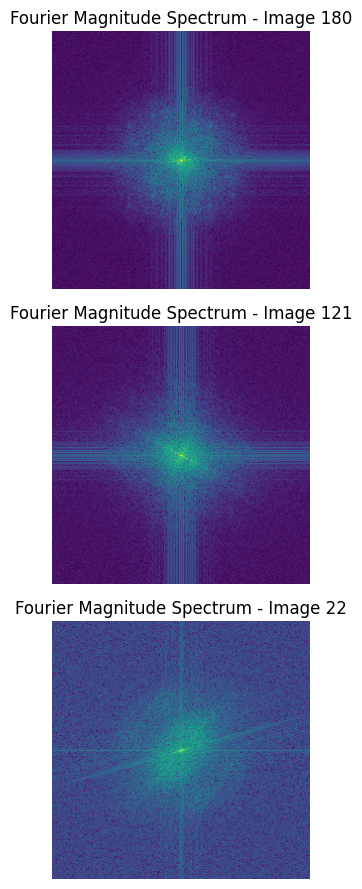

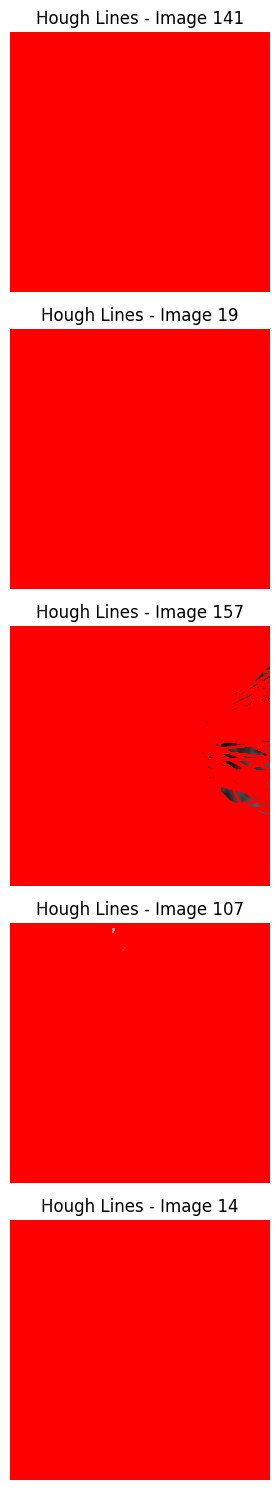

In [52]:
visualize_fourier_magnitude_spectra(fourier_images, num_to_show=3)
visualize_hough_line_results(hough_images, num_to_show=5)

In [10]:
roundness_values = calculate_roundness(images)
# print("Roundness values for all images:", roundness_values)

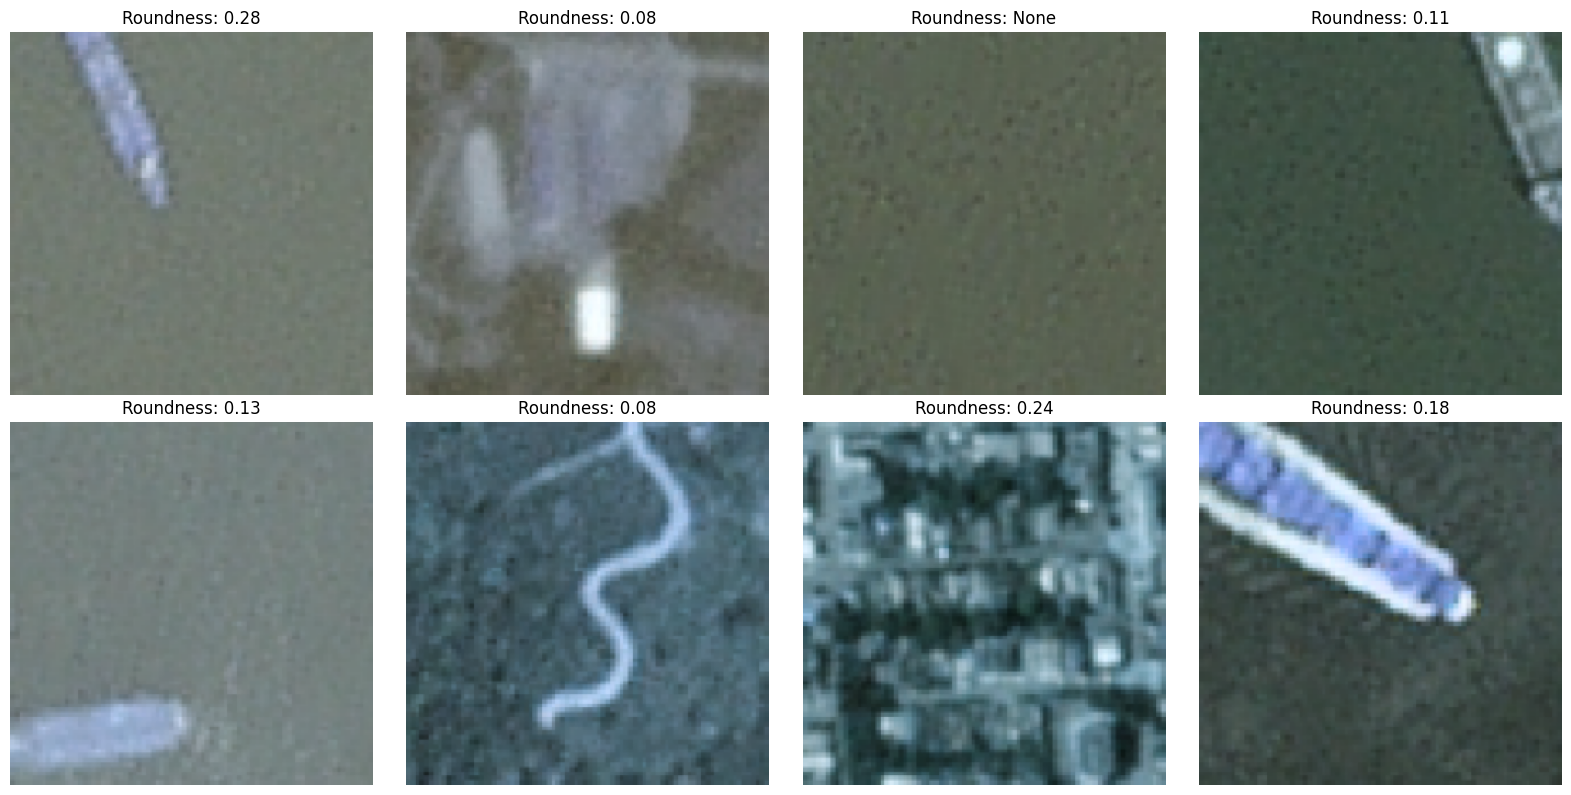

In [13]:
#Visualize the images and their roundness
combined = list(zip(images, roundness_values))
random.shuffle(combined)

max_images = 8
sampled = combined[:max_images]
cols = min(4, len(sampled))
rows = (len(sampled) + cols - 1) // cols

plt.figure(figsize=(4 * cols, 4 * rows))
for i, (img, roundness) in enumerate(sampled):
    plt.subplot(rows, cols, i + 1)

    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')

    title = f"Roundness: {roundness:.2f}" if roundness is not None else "Roundness: None"
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

From the above result which we can see here we can conclude that the roundess of a dataset works really weel for classfying ships through stalelite imagery. For any value over 0.20 the data, this method has identified all the ship in general. Because according to the images taken by sattelite the this is more of a localization problem so we are able to get very fast accurat using this

In [14]:
roundness_values = calculate_roundness(grayscale_images)
# print("Roundness values for all images:", roundness_values)

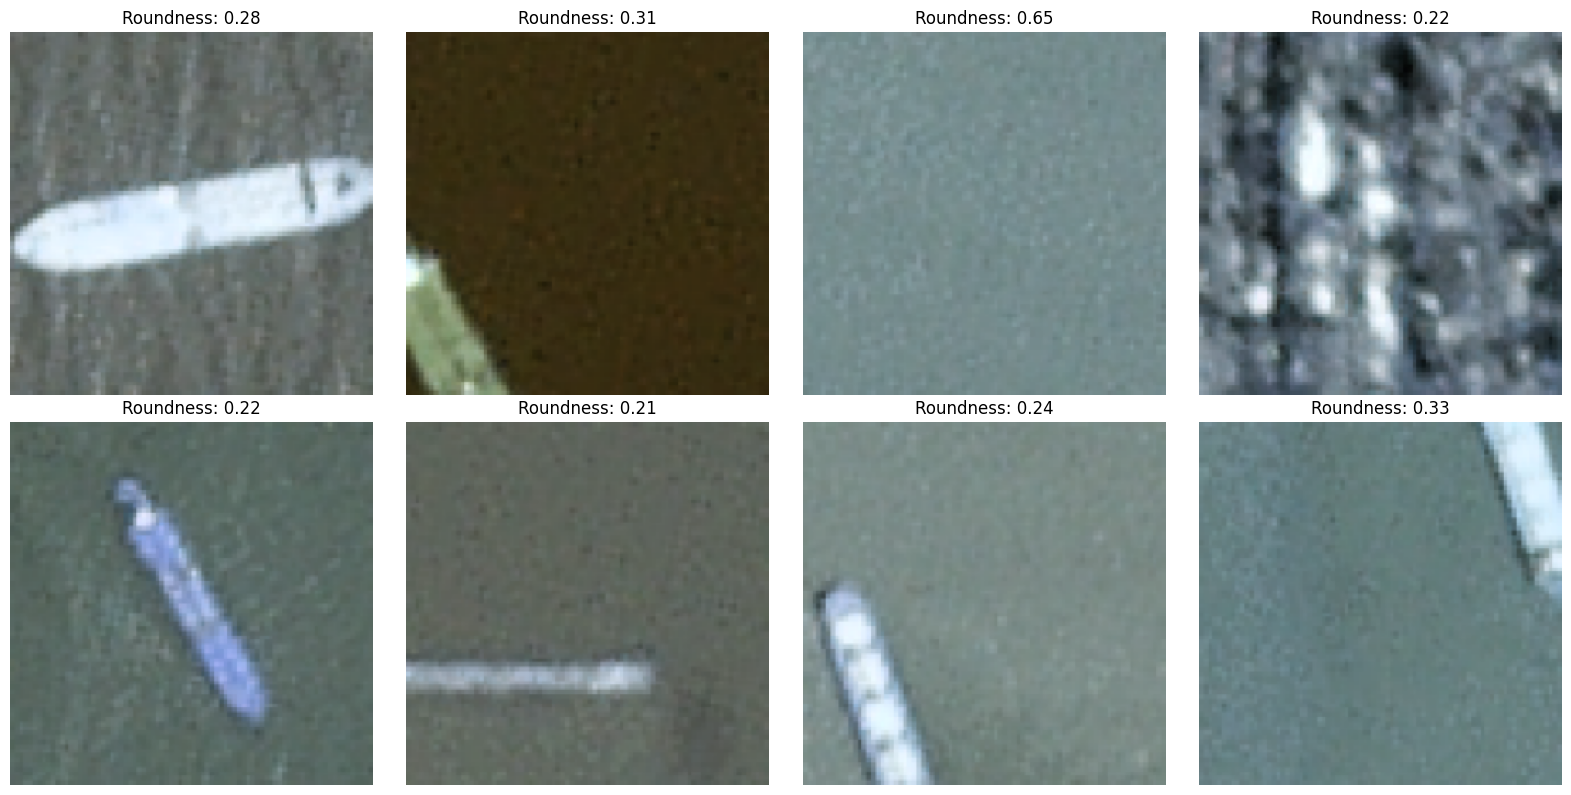

In [20]:
#Visualize the images and their roundness
combined = list(zip(images, roundness_values))
random.shuffle(combined)

max_images = 8
sampled = combined[:max_images]
cols = min(4, len(sampled))
rows = (len(sampled) + cols - 1) // cols

plt.figure(figsize=(4 * cols, 4 * rows))
for i, (img, roundness) in enumerate(sampled):
    plt.subplot(rows, cols, i + 1)

    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')

    title = f"Roundness: {roundness:.2f}" if roundness is not None else "Roundness: None"
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
def filter_images_by_roundness(images, roundness_values, min_val=0.15, max_val=0.5):
    """
    Returns images and roundness values where roundness is between min_val and max_val (inclusive).

    Args:
        images (list): List of images (numpy arrays).
        roundness_values (list): Corresponding roundness values.
        min_val (float): Minimum roundness value.
        max_val (float): Maximum roundness value.

    Returns:
        filtered_images (list): Images with roundness in the specified range.
        filtered_roundness (list): Corresponding roundness values.
    """
    filtered_images = []
    filtered_roundness = []

    for img, r in zip(images, roundness_values):
        if r is not None and min_val <= r <= max_val:
            filtered_images.append(img)
            filtered_roundness.append(r)

    return filtered_images, filtered_roundness


In [31]:
filtered_imgs, filtered_roundness = filter_images_by_roundness(images, roundness_values)

print(f"Found {len(filtered_imgs)} images with roundness between 0.15 and 0.50.")

Found 2234 images with roundness between 0.15 and 0.50.


The number 2299 is not that far off fromt the total number of ships classification which the more advanced Neural Networks were able to provie to us. According to the creaters of the dataset the there are roughly 2000 images with ships. And even if we able to classify this to some decent accuracy this seems like a good usecase for live monitoring of ships.